## Data preprocessing, model training and evaluation.

In [ ]:
#Описание проекта
#Этот блокнот реализует полный ML-пайплайн для многоклассовой классификации типов транспортных средств на основе характеристик их силуэтов с использованием набора данных Statlog из UCI.
#Цель проекта — классифицировать транспортные средства на 4 категории: фургон (van), Saab, автобус (bus), Opel. Датасет содержит геометрические параметры силуэтов, на основе которых модель определяет класс автомобиля.

### 1. Reading the data
This is the work with the [dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29), describing different cars for multiclass ($k=4$) classification problem. The data is available below.
The dataset contains 846 samples with 18 features describing vehicle silhouettes

In [ ]:
#If on colab, uncomment the following lines

#! wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_made/homeworks/lab01_ml_pipeline/car_data.csv

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.simplefilter("ignore")  # Suppress warnings for cleaner output

dataset = pd.read_csv('/content/car_data.csv', delimiter=',', header=None).values
data = dataset[:, 1:-1].astype(int)
target = dataset[:, -1]


print(data.shape, target.shape)
#train-Test Split
#Split data into training (65%) and testing (35%) sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.35)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(846, 18) (846,)
(549, 18) (549,) (297, 18) (297,)


In [ ]:
### Observations from Initial Exploration:
- Dataset has 846 samples with 18 numerical features
- No missing values detected
- Features appear to be on different scales (will need scaling)
- Target variable contains 4 classes: van, saab, bus, opel

In [ ]:
X_train_pd = pd.DataFrame(X_train)
### Initial Data Exploration
#Let's examine the first 15 rows and basic statistics
# First 15 rows of our dataset.
X_train_pd.head(15)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,98,55,104,213,67,9,206,32,23,167,223,629,220,72,5,19,187,196
1,96,39,58,117,51,6,133,52,18,139,154,255,150,86,6,0,181,182
2,105,54,100,220,69,10,221,30,25,170,232,718,202,73,0,13,187,199
3,81,43,68,125,57,8,149,46,19,146,169,323,172,83,6,18,179,184
4,103,55,100,194,62,11,212,31,24,175,217,666,219,73,10,14,187,194
5,85,43,66,130,57,6,151,45,19,143,173,333,168,86,4,9,180,183
6,108,49,109,204,61,11,212,31,24,159,229,665,215,71,16,11,190,199
7,91,46,101,199,65,9,196,34,23,146,219,574,199,73,5,8,186,194
8,89,47,80,131,54,11,160,43,20,163,175,369,174,77,1,7,182,193
9,90,42,63,144,59,7,131,50,18,142,154,259,162,65,15,3,197,204


Methods `describe` and `info` deliver some useful information.

In [ ]:
X_train_pd.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,549.00000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000
mean,93.57377,44.612022,81.734062,167.956284,61.575592,8.515483,167.934426,41.154827,20.495446,147.429872,188.109290,435.719490,173.806922,72.433515,6.400729,12.397086,189.080146,195.706740
std,8.23140,6.152319,15.707126,32.894294,8.068379,4.584789,33.388381,7.849618,2.601669,14.328176,32.003919,177.656135,33.029282,7.634777,4.867560,8.834801,6.176904,7.515651
min,76.00000,33.000000,40.000000,109.000000,47.000000,2.000000,112.000000,26.000000,17.000000,119.000000,130.000000,184.000000,109.000000,60.000000,0.000000,0.000000,176.000000,181.000000
25%,87.00000,39.000000,70.000000,141.000000,57.000000,7.000000,145.000000,34.000000,19.000000,136.000000,166.000000,313.000000,148.000000,67.000000,2.000000,5.000000,185.000000,191.000000
50%,93.00000,44.000000,78.000000,165.000000,61.000000,8.000000,155.000000,43.000000,19.000000,145.000000,177.000000,359.000000,172.000000,71.000000,6.000000,11.000000,189.000000,197.000000
75%,100.00000,49.000000,98.000000,194.000000,65.000000,10.000000,197.000000,46.000000,23.000000,159.000000,216.000000,578.000000,198.000000,76.000000,10.000000,19.000000,193.000000,201.000000
max,116.00000,58.000000,112.000000,333.000000,138.000000,55.000000,265.000000,61.000000,29.000000,188.000000,320.000000,1018.000000,262.000000,135.000000,22.000000,38.000000,206.000000,211.000000


In [ ]:
X_train_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       549 non-null    int64
 1   1       549 non-null    int64
 2   2       549 non-null    int64
 3   3       549 non-null    int64
 4   4       549 non-null    int64
 5   5       549 non-null    int64
 6   6       549 non-null    int64
 7   7       549 non-null    int64
 8   8       549 non-null    int64
 9   9       549 non-null    int64
 10  10      549 non-null    int64
 11  11      549 non-null    int64
 12  12      549 non-null    int64
 13  13      549 non-null    int64
 14  14      549 non-null    int64
 15  15      549 non-null    int64
 16  16      549 non-null    int64
 17  17      549 non-null    int64
dtypes: int64(18)
memory usage: 77.3 KB


### 2. Machine Learning pipeline


#### 2.0. Data preprocessing


In [ ]:
#Check for Missing Values

missing_values = np.isnan(data).sum()

print(f"Общее количество пропущенных значений в признаках: {missing_values}")
# Encode Target Variable
#Convert string labels to numerical values

label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)
#Feature Scaling
#Standardize features to have mean=0 and variance=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames with descriptive column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=[f'Feature{i}' for i in range(X_train_scaled.shape[1])])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=[f'Feature{i}' for i in range(X_test_scaled.shape[1])])

missing_values = np.isnan(X_train_scaled).sum()
print(f"Общее количество пропущенных значений в признаках: {missing_values}")

print("Размер тренировочного набора данных:", X_train_scaled.shape)
print("Размер тестового набора данных:", X_test_scaled.shape)


Общее количество пропущенных значений в признаках: 0
Общее количество пропущенных значений в признаках: Feature0     0
Feature1     0
Feature2     0
Feature3     0
Feature4     0
Feature5     0
Feature6     0
Feature7     0
Feature8     0
Feature9     0
Feature10    0
Feature11    0
Feature12    0
Feature13    0
Feature14    0
Feature15    0
Feature16    0
Feature17    0
dtype: int64
Размер тренировочного набора данных: (549, 18)
Размер тестового набора данных: (297, 18)


In [ ]:
"""
### 3.5 Preprocessing Conclusions:
- Target variable successfully encoded numerically
- Data split into training and test sets
- Features standardized to similar scales
- Ready for model training
"""

#### 2.1. Basic logistic regression


In [ ]:
#Logistic Regression with Hyperparameter Tuning
#We'll use GridSearchCV to find optimal parameters

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}
# Initialize logistic regression for multiclass classification
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    tol=1e-3,
    max_iter=500
)

grid_search_lr = GridSearchCV(log_reg, param_grid_lr, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search_lr.fit(X_train_scaled, y_train)

best_params_lr = grid_search_lr.best_params_
best_model_lr = grid_search_lr.best_estimator_

y_pred_lr = best_model_lr.predict(X_test_scaled)
y_proba_lr = best_model_lr.predict_proba(X_test_scaled)

f1_lr = f1_score(y_test, y_pred_lr, average='macro')
accuracy_lr = accuracy_score(y_test, y_pred_lr)

best_params_lr, round(f1_lr, 2), round(accuracy_lr, 2)


({'C': 10, 'penalty': 'l1'}, 0.79, 0.78)

Общий AUC (macro) для многоклассовой логистической регрессии (One-vs-Rest): 0.94


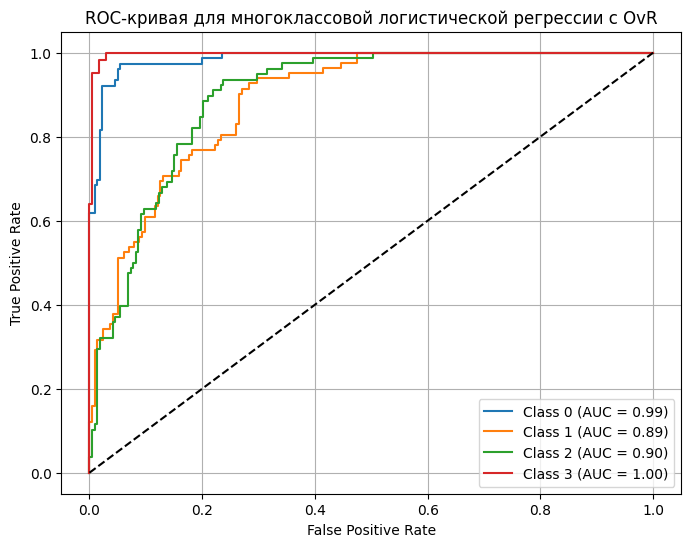

In [ ]:
y_proba_lr = best_model_lr.predict_proba(X_test_scaled)

n_classes = y_proba_lr.shape[1]

# Преобразуем y_test в бинарный формат для использования с OvR (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Вычисление AUC для многоклассовой логистической регрессии с OvR
logit_roc_auc = roc_auc_score(y_test_bin, best_model_lr.predict_proba(X_test_scaled), multi_class='ovr', average='macro')
print(f"Общий AUC (macro) для многоклассовой логистической регрессии (One-vs-Rest): {logit_roc_auc:.2f}")

n_classes = y_test_bin.shape[1]
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], best_model_lr.predict_proba(X_test_scaled)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая для многоклассовой логистической регрессии с OvR")
plt.legend(loc="lower right")
plt.grid(True)

plt.show()

#### 2.2. PCA: explained variance plot


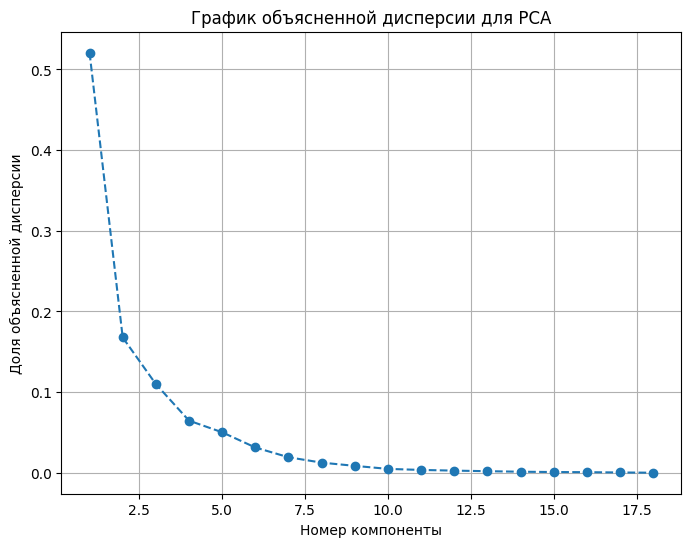

In [ ]:
pca = PCA()
pca.fit(X_train_scaled)


explained_variance = pca.explained_variance_ratio_


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title("График объясненной дисперсии для PCA")
plt.xlabel("Номер компоненты")
plt.ylabel("Доля объясненной дисперсии")
plt.grid(True)
plt.show()


#### 2.3. PCA trasformation


In [ ]:
# Применяем PCA с уменьшением размерности до подходящего числа компонент
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


print(f"Количество выбранных компонент: {pca.n_components_}")
print(f"Объясненная дисперсия: {sum(pca.explained_variance_ratio_):.2f}")


Количество выбранных компонент: 7
Объясненная дисперсия: 0.96


In [ ]:
 Мы выбираем количество компонент, которое объясняет 95% дисперсии, что помогает уменьшить размерность, сохраняя основную информацию.
Нормализация (стандартизация) данных важна, так как PCA чувствителен к масштабам признаков.
Мы используем fit_transform для обучения и трансформации тренировочных данных, а для тестовых данных — метод transform.

#### 2.4. Logistic regression on PCA-preprocessed data.


Общий AUC (macro) для многоклассовой логистической регрессии (One-vs-Rest): 0.85


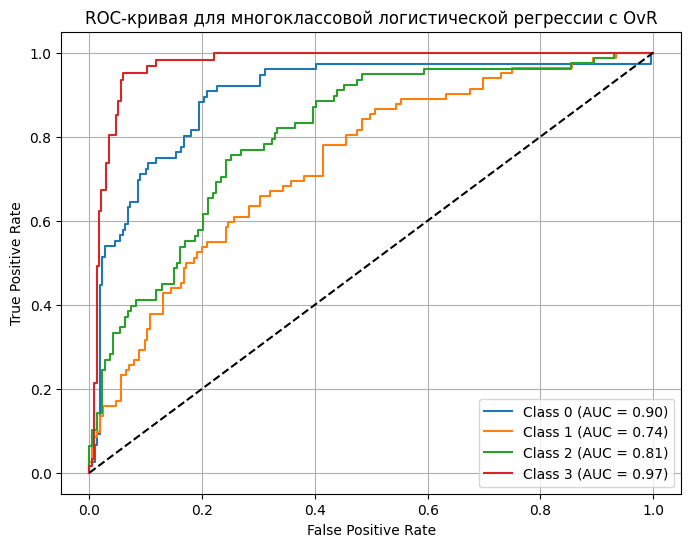

({'C': 1, 'penalty': 'l2'}, 0.62, 0.63)

In [ ]:
param_grid_pca = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

log_reg_pca = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    tol=1e-3,
    max_iter=500
)

grid_search_pca = GridSearchCV(log_reg_pca, param_grid_pca, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search_pca.fit(X_train_pca, y_train)

best_params_pca = grid_search_pca.best_params_


best_model_pca = grid_search_pca.best_estimator_
y_pred_pca = best_model_pca.predict(X_test_pca)
y_proba_pca = best_model_pca.predict_proba(X_test_pca)


f1_pca = f1_score(y_test, y_pred_pca, average='macro')
accuracy_pca = accuracy_score(y_test, y_pred_pca)

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

y_proba_pca = best_model_pca.predict_proba(X_test_pca)

n_classes = y_proba_pca.shape[1]

# Преобразуем y_test в бинарный формат для использования с OvR (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

logit_roc_auc = roc_auc_score(y_test_bin, y_proba_pca, multi_class='ovr', average='macro')
print(f"Общий AUC (macro) для многоклассовой логистической регрессии (One-vs-Rest): {logit_roc_auc:.2f}")

plt.figure(figsize=(8, 6))


for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_pca[:, i])
    roc_auc = auc(fpr, tpr)  # AUC для класса
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая для многоклассовой логистической регрессии с OvR")
plt.legend(loc="lower right")
plt.grid(True)

plt.show()

best_params_pca, round(f1_pca, 2), round(accuracy_pca, 2)



#### 2.5. Decision tree


In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)

param_grid_tree = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
}

grid_search_tree = GridSearchCV(tree, param_grid_tree, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search_tree.fit(X_train_scaled, y_train)

best_tree_params = grid_search_tree.best_params_

best_tree_model = grid_search_tree.best_estimator_
y_pred_tree = best_tree_model.predict(X_test_scaled)


f1_tree = f1_score(y_test, y_pred_tree, average='macro')
accuracy_tree = accuracy_score(y_test, y_pred_tree)


best_tree_params, round(f1_tree, 2), round(accuracy_tree, 2)


({'max_depth': 15}, 0.7, 0.69)

#### 2.6. Bagging.
Here starts the ensembling part.

First we will use the __Bagging__ approach. Build an ensemble of $N$ algorithms varying N from $N_{min}=2$ to $N_{max}=100$ (with step 5).

We will build two ensembles: of logistic regressions and of decision trees.


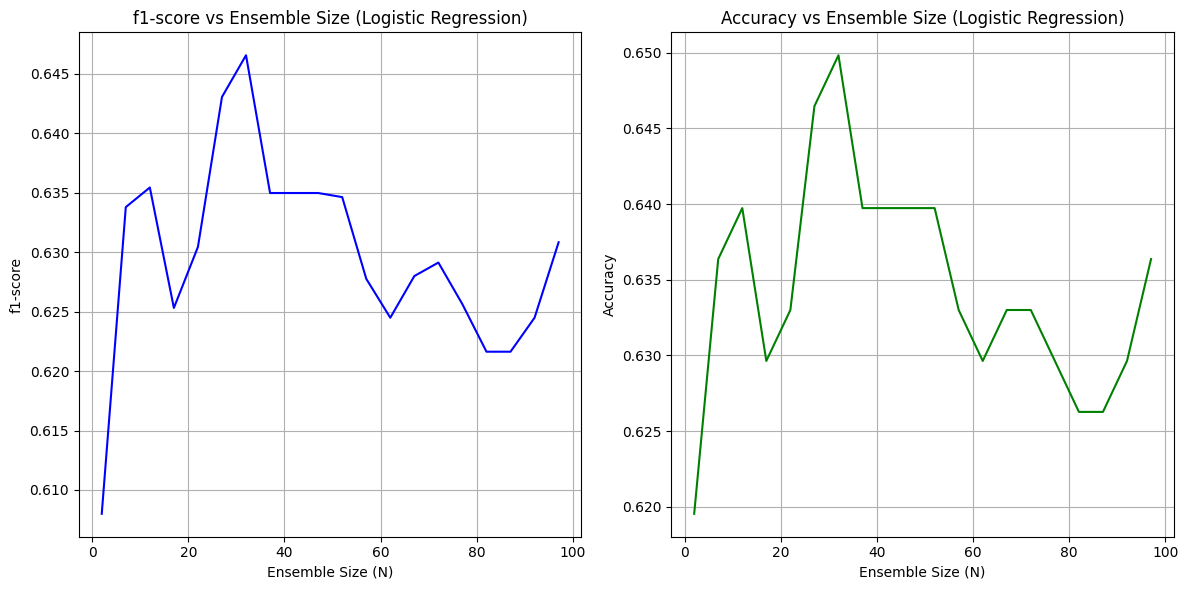

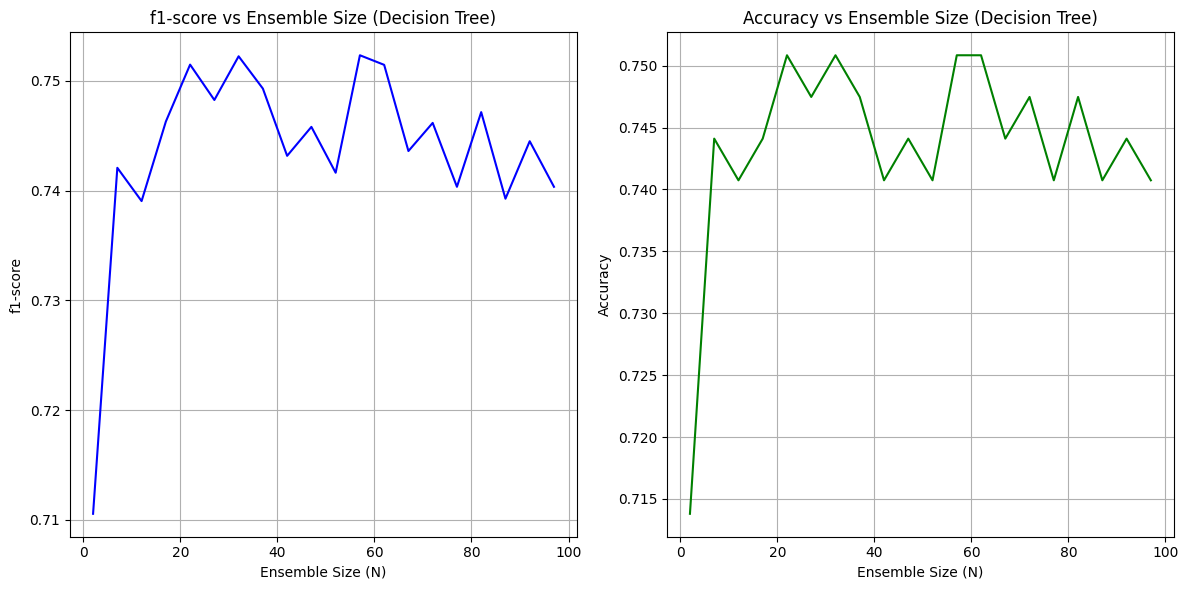

In [ ]:
from sklearn.ensemble import BaggingClassifier
def build_bagging_ensemble(X_train_scaled, y_train, X_test_scaled, y_test, model_type='logreg', Nmin=2, Nmax=100, step=5):
    f1_bagging = []
    accuracy_bagging = []

    for N in range(Nmin, Nmax + 1, step):
        if model_type == 'logreg':
            model = best_model_lr
        elif model_type == 'dt':
            model = best_tree_model

        bagging_model = BaggingClassifier(estimator=model, n_estimators=N, random_state=42)

        bagging_model.fit(X_train_scaled, y_train)

        y_pred = bagging_model.predict(X_test_scaled)

        f1_bagging.append(f1_score(y_test, y_pred, average='macro'))
        accuracy_bagging.append(accuracy_score(y_test, y_pred))

    return f1_bagging, accuracy_bagging


f1_logreg, accuracy_logreg = build_bagging_ensemble(X_train_pca, y_train, X_test_pca, y_test, model_type='logreg')
f1_dt, accuracy_dt = build_bagging_ensemble(X_train_scaled, y_train, X_test_scaled, y_test, model_type='dt')


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 101, 5), f1_logreg, label='f1-score (Logistic Regression)', color='blue')
plt.title('f1-score vs Ensemble Size (Logistic Regression)')
plt.xlabel('Ensemble Size (N)')
plt.ylabel('f1-score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(2, 101, 5), accuracy_logreg, label='Accuracy (Logistic Regression)', color='green')
plt.title('Accuracy vs Ensemble Size (Logistic Regression)')
plt.xlabel('Ensemble Size (N)')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 101, 5), f1_dt, label='f1-score (Decision Tree)', color='blue')
plt.title('f1-score vs Ensemble Size (Decision Tree)')
plt.xlabel('Ensemble Size (N)')
plt.ylabel('f1-score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(2, 101, 5), accuracy_dt, label='Accuracy (Decision Tree)', color='green')
plt.title('Accuracy vs Ensemble Size (Decision Tree)')
plt.xlabel('Ensemble Size (N)')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


Логистическая регрессия

F1-score и Accuracy растут при малых N, но после ~40 моделей начинается хаотичное поведение.
После 60-70 моделей качество не улучшается, а иногда ухудшается.
Дерево решений (max_depth=15)

Качество резко растет на первых 20-30 моделях, затем выходит на плато.
После 50 моделей F1-score и Accuracy становятся нестабильными — это признак переобучения.
Глубокие деревья могут переобучаться даже в ансамбле, особенно если max_depth=15.
 Оптимальное количество моделей в ансамбле
Логистическая регрессия: 30-40 моделей, после чего качество стабилизируется.
Дерево решений (max_depth=15): 25-40 моделей, после чего эффект от добавления новых моделей становится минимальным или даже негативным.

В 2.5 было найдено max_depth=15 как оптимальное для одиночного дерева.
Для ансамбля глубокие деревья (max_depth=15) могут переобучаться, так как каждое дерево может слишком сильно запоминать данные.


#### 2.7. Random Forest
Now we will work with the Random Forest

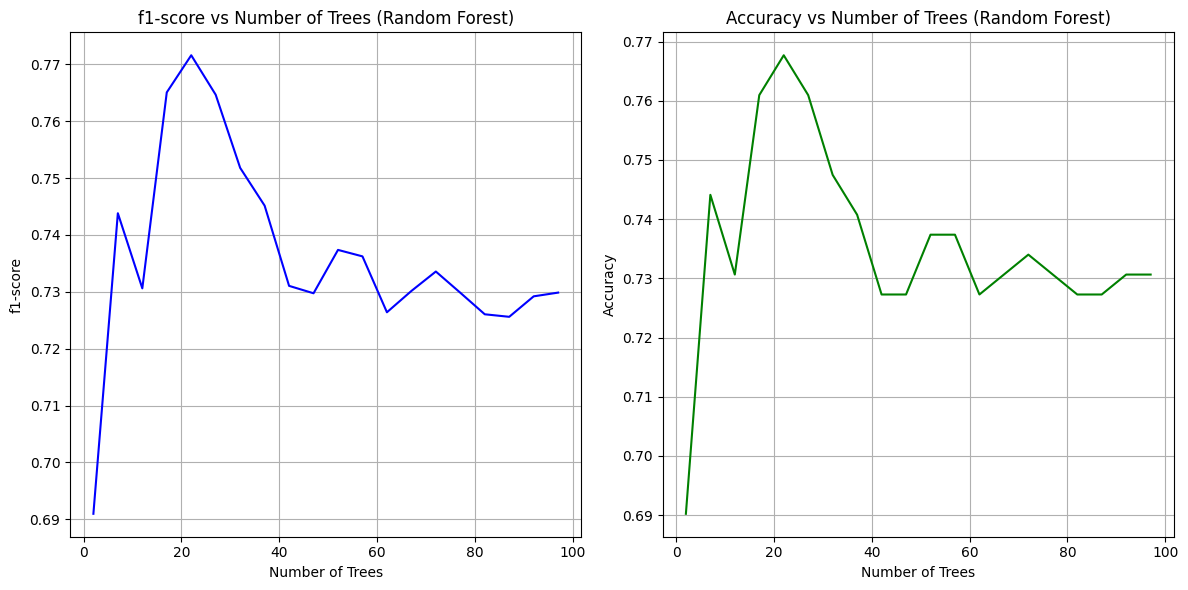

In [ ]:
from sklearn.ensemble import RandomForestClassifier

best_tree_params = grid_search_tree.best_params_
def build_random_forest(X_train_scaled, y_train, X_test_scaled, y_test, Nmin=2, Nmax=100, step=5):
    f1_rf = []
    accuracy_rf = []

    for N in range(Nmin, Nmax + 1, step):
        rf_model = RandomForestClassifier(n_estimators=N, max_depth=best_tree_params["max_depth"], random_state=42, n_jobs=-1)

        rf_model.fit(X_train_scaled, y_train)

        y_pred = rf_model.predict(X_test_scaled)

        f1_rf.append(f1_score(y_test, y_pred, average='macro'))
        accuracy_rf.append(accuracy_score(y_test, y_pred))

    return f1_rf, accuracy_rf

f1_rf, accuracy_rf = build_random_forest(X_train_scaled, y_train, X_test_scaled, y_test, Nmin=2, Nmax=100, step=5)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 101, 5), f1_rf, label='f1-score (Random Forest)', color='blue')
plt.title('f1-score vs Number of Trees (Random Forest)')
plt.xlabel('Number of Trees')
plt.ylabel('f1-score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(2, 101, 5), accuracy_rf, label='Accuracy (Random Forest)', color='green')
plt.title('Accuracy vs Number of Trees (Random Forest)')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()



F1-score и Accuracy сначала быстро растут, достигая пика примерно на 20-30 деревьях.
После 40 деревьев наблюдается нестабильность, а после 50-60 деревьев качество перестает улучшаться.
После 70 деревьев результаты становятся практически неизменными.
Оптимальное количество деревьев: 23.

В 2.6 (ансамбли логистической регрессии и деревьев решений) оптимальное число моделей было 30.

Для логистической регрессии (~30-40 моделей) добавление моделей не давало сильного прироста после 40 моделей.
Для деревьев решений (оптимально 30-50 моделей) зависимость была похожей, но колебания были более выражены.
Для случайного леса (Random Forest) оптимальное число деревьев немного меньше: 20-40 деревьев достаточно для достижения хорошего качества.
Случайный лес уже использует ансамблирование и лучше регулирует переобучение.







#### 2.8. Learning curve
The goal is to estimate, how does the model behaviour change with the increase of the `train` dataset size.


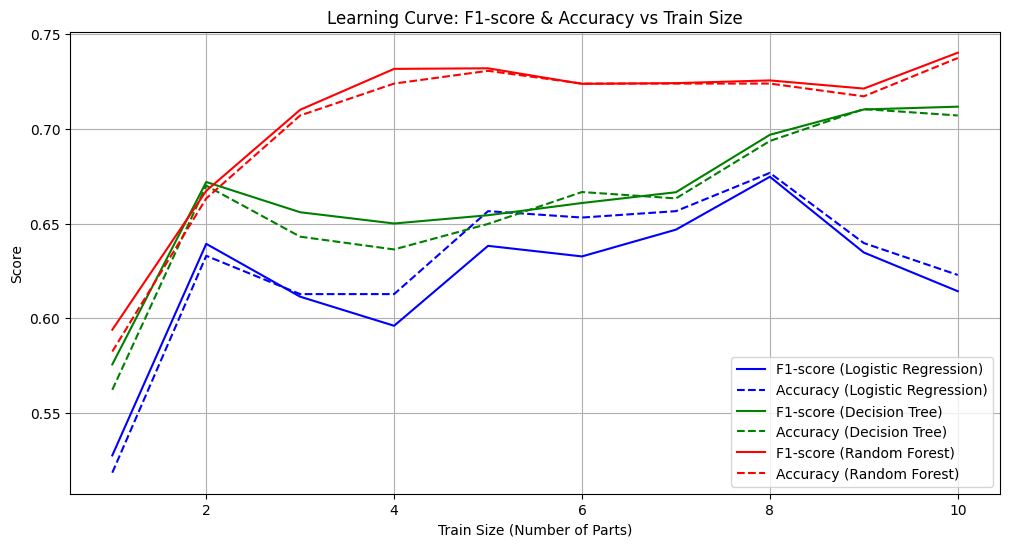

In [ ]:
def plot_learning_curve(X_train, y_train, X_test, y_test, model_type='logreg', N_parts=10):
    f1_scores = []
    accuracy_scores = []


    part_size = len(X_train) // N_parts
    for i in range(1, N_parts + 1):
        X_train_part = X_train[:i * part_size]
        y_train_part = y_train[:i * part_size]

        # Инициализация модели
        if model_type == 'logreg':
            model = LogisticRegression(multi_class='multinomial', solver='saga', tol=1e-3, max_iter=500)
        elif model_type == 'dt':
            model = DecisionTreeClassifier(random_state=42)
        elif model_type == 'rf':
            model = RandomForestClassifier(n_estimators=50, random_state=42)

        model.fit(X_train_part, y_train_part)

        y_pred = model.predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred, average='macro'))
        accuracy_scores.append(accuracy_score(y_test, y_pred))

    return f1_scores, accuracy_scores

# Построение learning curve
f1_logreg, accuracy_logreg = plot_learning_curve(X_train_pca, y_train, X_test_pca, y_test, model_type='logreg')
f1_dt, accuracy_dt = plot_learning_curve(X_train_scaled, y_train, X_test_scaled, y_test, model_type='dt')
f1_rf, accuracy_rf = plot_learning_curve(X_train_scaled, y_train, X_test_scaled, y_test, model_type='rf')


plt.figure(figsize=(12, 6))

train_sizes = range(1, 11)

# Логистическая регрессия (Logistic Regression)
plt.plot(train_sizes, f1_logreg, label='F1-score (Logistic Regression)', color='blue', linestyle='-')
plt.plot(train_sizes, accuracy_logreg, label='Accuracy (Logistic Regression)', color='blue', linestyle='--')

# Дерево решений (Decision Tree)
plt.plot(train_sizes, f1_dt, label='F1-score (Decision Tree)', color='green', linestyle='-')
plt.plot(train_sizes, accuracy_dt, label='Accuracy (Decision Tree)', color='green', linestyle='--')

# Случайный лес (Random Forest)
plt.plot(train_sizes, f1_rf, label='F1-score (Random Forest)', color='red', linestyle='-')
plt.plot(train_sizes, accuracy_rf, label='Accuracy (Random Forest)', color='red', linestyle='--')

plt.title('Learning Curve: F1-score & Accuracy vs Train Size')
plt.xlabel('Train Size (Number of Parts)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.show()



Все модели улучшаются при увеличении количества обучающих данных.
На первых 2-3 частях рост особенно заметен, затем модели начинают вести себя по-разному.
Random Forest показывает наилучшие результаты, а логистическая регрессия — наихудшие.
- Логистическая регрессия
Резкий рост на первых 2 частях, затем колебания.
После 4-й части наблюдается замедление роста, а к концу даже снижение.
Вывод: Логистическая регрессия плохо масштабируется на большие объемы данных.
-Дерево решений
Быстро растет на первых 2-3 частях, но затем начинает колебаться.
После 5-6 частей показывает небольшие улучшения, но без явного скачка.
Вывод: Дерево решений чувствительно к количеству данных. Оно быстро обучается, но затем начинает переобучаться или сталкиваться с ограничением глубины.
-Случайный лес
Самая устойчивая модель: F1-score и Accuracy постепенно растут на всех частях обучающих данных.
Кривая стабилизируется на высоком уровне, без резких спадов.
Вывод: Случайный лес лучше всего использует увеличение данных. Это объясняется тем, что ансамбли деревьев снижают переобучение.
Random Forest — лучшая модель. Он стабильно улучшает результаты по мере увеличения данных и показывает наивысший F1-score и Accuracy.Decision Tree хорошо работает на малых данных, но затем его качество колеблется, возможно, из-за переобучения.
Logistic Regression имеет ограниченную силу, особенно на больших объемах данных. Она не справляется с задачей так же хорошо, как другие модели.
